# Load data

In [3]:
!pip install rasterio

zsh:1: command not found: pip


In [2]:
import geopandas as gpd
import pandas as pd

In [4]:
subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')
well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')

# find downstream gage

In [11]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Convert gage dataframe to GeoDataFrame (to match with subbasin_gdf)
# Create point geometries from longitude/latitude coordinates
gage_gdf = gpd.GeoDataFrame(
    gage_df,
    geometry=gpd.points_from_xy(gage_df['longitude'], gage_df['latitude']),
    crs=subbasin_gdf.crs
)

# Spatial join to find which subbasin each gage falls within
# Only keep gages that are within a subbasin (inner join)
matched_gages = gpd.sjoin(
    gage_gdf[['id', 'name', 'geometry']],
    subbasin_gdf[['linkno', 'geometry']],
    how='inner',
    predicate='within'
).rename(columns={'linkno': 'catchment_id'})

# Keep only relevant columns
matched_gages = matched_gages[['id', 'name', 'geometry', 'catchment_id']]



In [12]:
# Create a directed graph representing the river network
import networkx as nx
G = nx.DiGraph()

# Add edges to graph based on stream connectivity
# DSLINKNO represents downstream link number
for _, row in stream_gdf.iterrows():
    if pd.notna(row['DSLINKNO']) and row['DSLINKNO'] > 0:
        G.add_edge(int(row['LINKNO']), int(row['DSLINKNO']))

# Create dictionary mapping gage IDs to their catchment IDs
gage_links = dict(zip(matched_gages['id'], matched_gages['catchment_id']))
terminal_ids = []

# Find terminal gages (those that don't flow to any other gage)
for g1_id, g1_link in gage_links.items():
    is_terminal = True
    for g2_id, g2_link in gage_links.items():
        if g1_id != g2_id:
            try:
                # If there's a path from g1 to g2, then g1 is not terminal
                if nx.has_path(G, g1_link, g2_link):
                    is_terminal = False
                    break
            except:
                continue
    if is_terminal:
        terminal_ids.append(g1_id)

In [13]:
# Manual adjustments to terminal gages list based on domain knowledge
gages_to_remove = [10171000, 10167000]
gages_to_add = [10163000, 10153100, 10152000]

In [14]:
# Remove specified gages
terminal_ids = [gage_id for gage_id in terminal_ids if gage_id not in gages_to_remove]

# Add new gages if they exist in matched_gages
for gage_id in gages_to_add:
    if gage_id in matched_gages['id'].values and gage_id not in terminal_ids:
        terminal_ids.append(gage_id)

# Create dataframe of terminal gages
terminal_gages = matched_gages[matched_gages['id'].isin(terminal_ids)].copy()

# Find all upstream catchments for each terminal gage
records = []
for _, gage in terminal_gages.iterrows():
    upstream_ids = set()
    # Check each node in the graph
    for node in G.nodes:
        # If there's a path from node to terminal gage's catchment,
        # then this node is upstream
        if nx.has_path(G, node, gage['catchment_id']):
            upstream_ids.add(node)
    # Include the terminal gage's own catchment
    upstream_ids.add(gage['catchment_id'])

    # Create records for each upstream catchment
    for up_id in upstream_ids:
        records.append({
            'Gage_ID': gage['id'],
            'Gage_Name': gage['name'],
            'Terminal_Catchment_ID': gage['catchment_id'],
            'Upstream_Catchment_ID': up_id
        })

# Create and save the final dataframe
df_upstream = pd.DataFrame(records)
df_upstream.to_csv("../data/processed/terminal_gage_upstream_catchments.csv", index=False)

In [16]:
print(f'Number of unique gages in df_upstream: {df_upstream["Gage_ID"].nunique()}')
print('\nTerminal gage names:')
for _, row in df_upstream[['Gage_ID', 'Gage_Name']].drop_duplicates().iterrows():
    print(f'{row["Gage_ID"]}: {row["Gage_Name"]}')


Number of unique gages in df_upstream: 12

Terminal gage names:
10126000: BEAR RIVER NEAR CORINNE - UT
10141000: WEBER RIVER NEAR PLAIN CITY - UT
10142000: FARMINGTON CR ABV DIV NR FARMINGTON - UTAH
10143500: CENTERVILLE CREEK ABV. DIV NEAR CENTERVILLE - UT
10152000: SPANISH FORK NEAR LAKE SHORE - UTAH
10153100: HOBBLE CREEK AT 1650 WEST AT SPRINGVILLE - UTAH
10163000: PROVO RIVER AT PROVO - UT
10168000: LITTLE COTTONWOOD CREEK @ JORDAN RIVER NR SLC
10168500: BIG COTTONWOOD CR NR SALT LAKE CITY UTAH
10172700: VERNON CREEK NEAR VERNON - UT
10172860: WARM CREEK NEAR GANDY - UT
10172952: DUNN CREEK NEAR PARK VALLEY - UT


# Plot

In [22]:
import matplotlib.pyplot as plt
plt.style.use('default')  # Reset any style settings

In [17]:
import plotly as plt
import plotly.express as px

=== Creating Enhanced Watershed Visualization ===


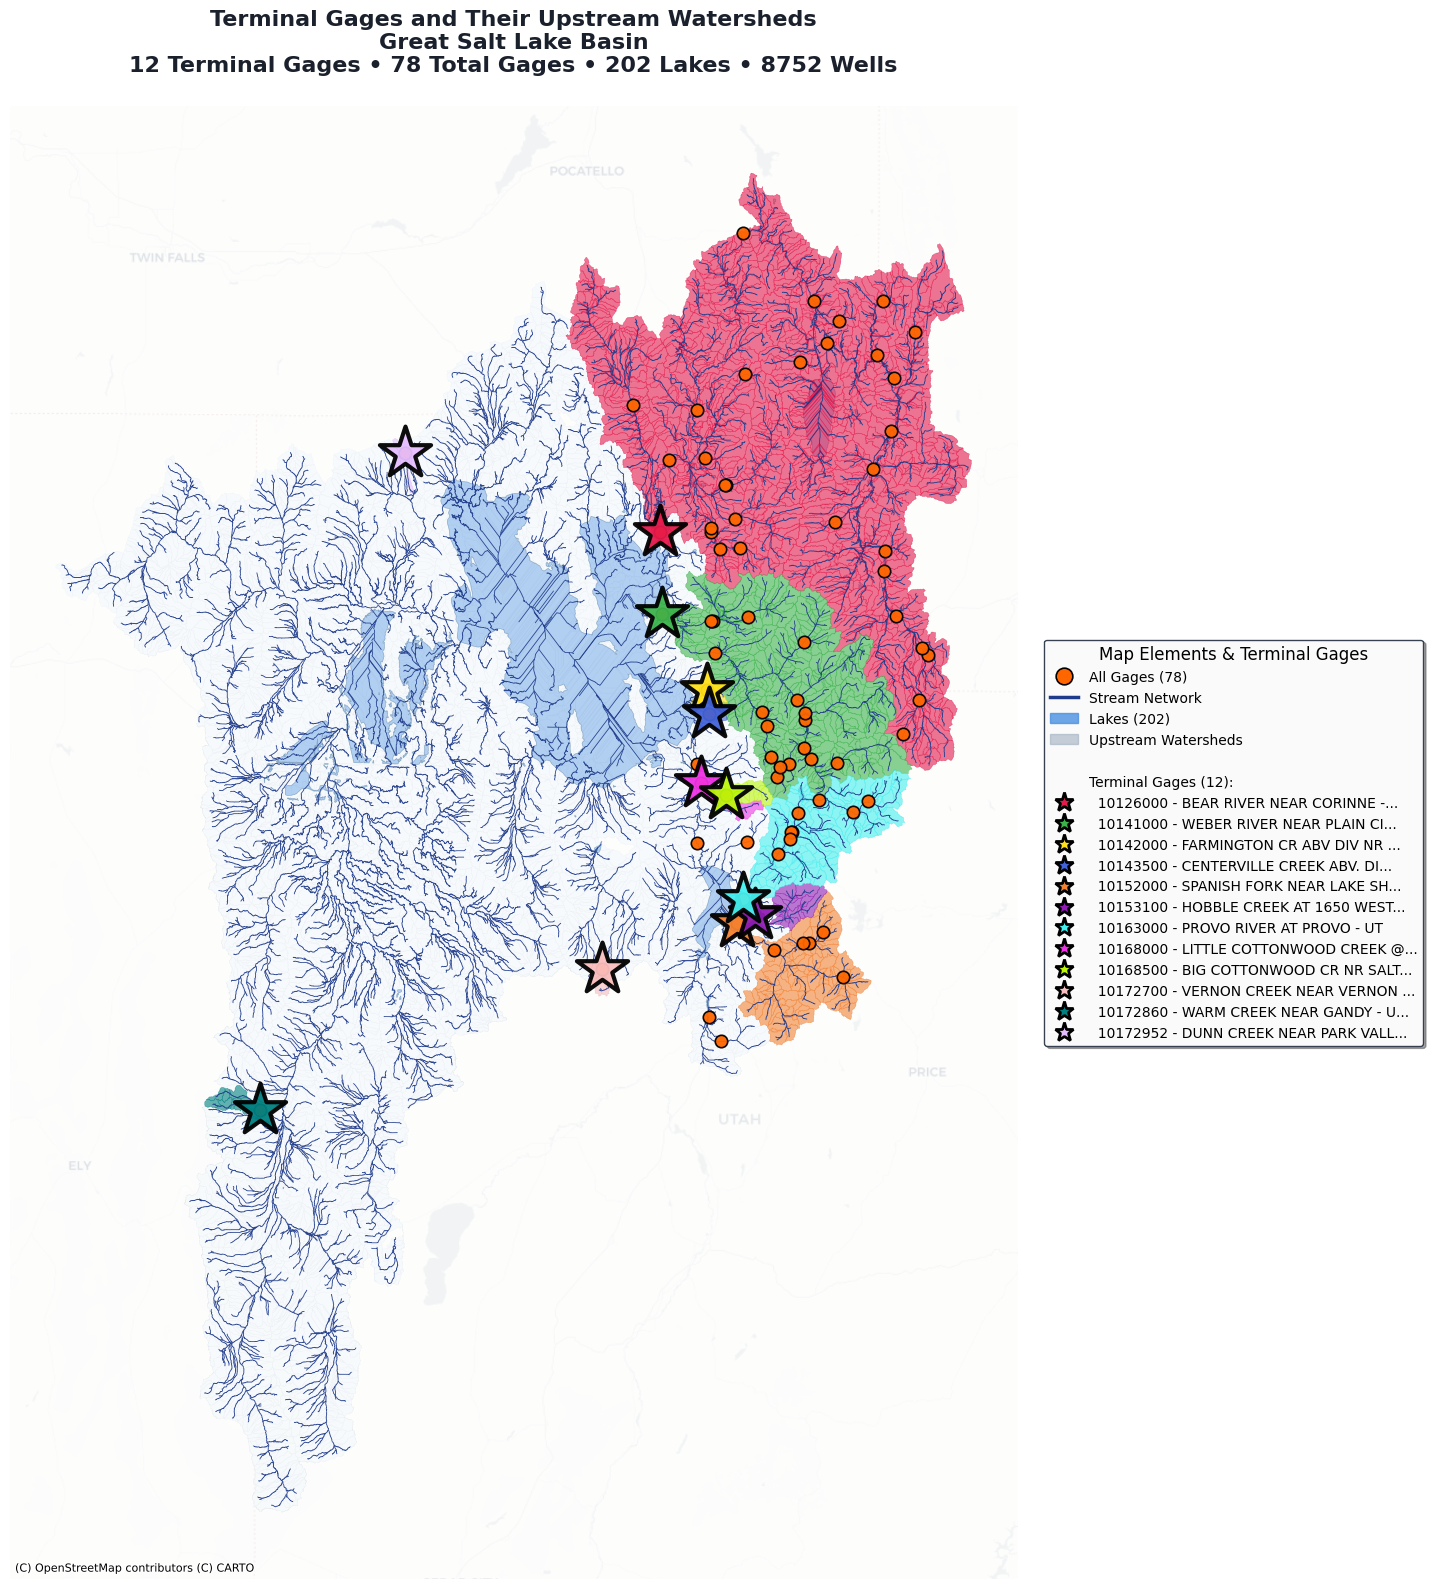

✅ Visualization saved to: reports/figures/enhanced_terminal_gages_watersheds.png
📊 Added 8752 wells to the visualization


In [25]:
def create_enhanced_watershed_visualization():
    """
    Create enhanced watershed visualization with bright colors and large gages
    """
    print("=== Creating Enhanced Watershed Visualization ===")

    # Load data
    terminal_mapping = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')
    well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
    stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
    # Find linkno column
    linkno_col = 'linkno' if 'linkno' in subbasin_gdf.columns else 'LINKNO'

    # Data preprocessing
    if 'Gage_ID' in terminal_mapping.columns:
        terminal_mapping = terminal_mapping.rename(columns={
            'Gage_ID': 'gage_id',
            'Upstream_Catchment_ID': 'upstream_catchment_id'
        })

    terminal_mapping = terminal_mapping.dropna(subset=['upstream_catchment_id'])
    terminal_mapping['gage_id'] = terminal_mapping['gage_id'].astype(int)
    terminal_mapping['upstream_catchment_id'] = terminal_mapping['upstream_catchment_id'].astype(int)

    gage_df['id'] = gage_df['id'].astype(int)
    subbasin_gdf = subbasin_gdf.dropna(subset=[linkno_col])
    subbasin_gdf[linkno_col] = subbasin_gdf[linkno_col].astype(int)

    # Get terminal gages and create catchments dictionary
    terminal_gage_ids = terminal_mapping['gage_id'].unique().tolist()
    terminal_gages = gage_df[gage_df['id'].isin(terminal_gage_ids)].copy()

    terminal_gage_catchments = {}
    available_catchments = set(subbasin_gdf[linkno_col].unique())

    for gage_id in terminal_gage_ids:
        upstream_catchments = terminal_mapping[
            terminal_mapping['gage_id'] == gage_id
        ]['upstream_catchment_id'].tolist()

        valid_catchments = [c for c in upstream_catchments if c in available_catchments]
        if valid_catchments:
            terminal_gage_catchments[gage_id] = set(valid_catchments)

    # Convert to Web Mercator
    subbasin_web = subbasin_gdf.to_crs('EPSG:3857')
    stream_web = stream_gdf.to_crs('EPSG:3857')
    lake_web = lake_gdf.to_crs('EPSG:3857')
    well_web = well_gdf.to_crs('EPSG:3857')  # Convert wells to Web Mercator

    gage_gdf_web = gpd.GeoDataFrame(
        gage_df,
        geometry=gpd.points_from_xy(gage_df['longitude'], gage_df['latitude']),
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')

    terminal_gages_web = gpd.GeoDataFrame(
        terminal_gages,
        geometry=gpd.points_from_xy(terminal_gages['longitude'], terminal_gages['latitude']),
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')

    # New bright professional colors
    bright_colors = [
    '#E6194B',  # 鲜红
    '#3CB44B',  # 明绿
    '#FFE119',  # 鲜黄
    '#4363D8',  # 宝蓝
    '#F58231',  # 橘色
    '#911EB4',  # 紫罗兰
    '#46F0F0',  # 湖蓝
    '#F032E6',  # 品红
    '#BCF60C',  # 黄绿
    '#FABEBE',  # 淡粉
    '#008080',  # 青绿色
    '#E6BEFF',  # 淡紫
    '#9A6324',  # 褐色
    '#FFFAC8',  # 象牙黄
    '#800000',  # 深红
    '#AAFFC3',  # 薄荷绿
    '#808000',  # 橄榄绿
    '#FFD8B1',  # 杏橙
    '#000075',  # 海军蓝
    '#808080'   # 中灰色
]

    terminal_gage_colors = dict(zip(terminal_gage_ids, bright_colors[:len(terminal_gage_ids)]))

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(22, 16))

    # 1. Plot subbasins background
    subbasin_web.plot(ax=ax, color='#F7FAFC', edgecolor='#E2E8F0', linewidth=0.1, alpha=0.9, zorder=1)

    # 2. Add lakes (darker blue, more visible)
    lake_web.plot(ax=ax, color='#4A90E2', edgecolor='#2E5F8A',  # Changed to darker blue
                  linewidth=0.5, alpha=0.4, zorder=1.5)  # Increased alpha for better visibility

    # 3. Highlight watersheds
    for gage_id in terminal_gage_ids:
        if gage_id in terminal_gage_catchments:
            upstream_catchments = list(terminal_gage_catchments[gage_id])
            upstream_basins = subbasin_web[subbasin_web[linkno_col].isin(upstream_catchments)]

            if not upstream_basins.empty:
                upstream_basins.plot(
                    ax=ax,
                    color=terminal_gage_colors[gage_id],
                    alpha=0.6,
                    edgecolor=terminal_gage_colors[gage_id],
                    linewidth=0.3,
                    zorder=2
                )

    # 4. Add streams (dark blue)
    stream_web.plot(ax=ax, color='#1E3A8A', linewidth=0.6, alpha=0.9, zorder=3)


    # 6. Plot all gages (bright and large)
    gage_gdf_web.plot(ax=ax, color='#FF6600', markersize=80, alpha=0.95,  # Much larger and brighter
                      edgecolor='#000000', linewidth=1.2, zorder=4)

    # 7. Plot terminal gages (bright stars)
    terminal_gage_info = []
    for _, row in terminal_gages_web.iterrows():
        gage_id = int(row['id'])

        if gage_id in terminal_gage_catchments:
            x_coord = row.geometry.x
            y_coord = row.geometry.y

            ax.scatter([x_coord], [y_coord],
                       c=[terminal_gage_colors[gage_id]],
                       marker='*', s=1500,  # Larger stars
                       edgecolors='#000000', linewidths=3.0,
                       zorder=5, alpha=0.95)

            # Collect info for legend
            gage_name = row.get('name', f'Gage {gage_id}')
            river = row.get('River', 'Unknown River')
            terminal_gage_info.append({
                'id': gage_id,
                'name': gage_name,
                'river': river,
                'color': terminal_gage_colors[gage_id]
            })

    # 8. Add base map
    try:
        import contextily as ctx
        ctx.add_basemap(ax, crs=subbasin_web.crs,
                        source=ctx.providers.CartoDB.Positron,
                        zorder=0, alpha=0.3)
    except:
        pass

    # 9. Create legend
    from matplotlib.patches import Patch

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='#FF6600', markersize=12,
                  markeredgecolor='#000000', markeredgewidth=1.2,
                  label=f'All Gages ({len(gage_df)})'),
        plt.Line2D([0], [0], color='#1E3A8A', linewidth=2.5,
                  label='Stream Network'),
        Patch(color='#4A90E2', alpha=0.8, label=f'Lakes ({len(lake_gdf)})'),  # Updated lake color in legend
        Patch(color='#A0AEC0', alpha=0.6, label='Upstream Watersheds'),
        plt.Line2D([0], [0], color='none', label=''),  # Spacer
        plt.Line2D([0], [0], color='none', label=f'Terminal Gages ({len(terminal_gage_info)}):')
    ]

    # Add terminal gages to legend
    terminal_gage_info.sort(key=lambda x: x['id'])
    for info in terminal_gage_info:
        display_name = info['name'][:25] + "..." if len(info['name']) > 25 else info['name']
        legend_elements.append(
            plt.Line2D([0], [0], marker='*', color='w',
                      markerfacecolor=info['color'], markersize=14,
                      markeredgecolor='#000000', markeredgewidth=2.0,
                      label=f'  {info["id"]} - {display_name}')
        )

    # Set legend
    ax.legend(handles=legend_elements,
             loc='center left', bbox_to_anchor=(1.02, 0.5),
             fontsize=10, title='Map Elements & Terminal Gages',
             title_fontsize=12, frameon=True, fancybox=True,
             shadow=True, framealpha=0.95, facecolor='white',
             edgecolor='#2D3748')

    # 10. Title
    ax.set_title(f"Terminal Gages and Their Upstream Watersheds\n"
                f"Great Salt Lake Basin\n"
                f"{len(terminal_gage_ids)} Terminal Gages • {len(gage_df)} Total Gages • {len(lake_gdf)} Lakes • {len(well_gdf)} Wells",
                fontsize=16, pad=25, fontweight='bold', color='#1A202C')

    # 11. Format and save
    ax.set_aspect('equal')
    ax.axis('off')
    ax.margins(0.01)
    plt.tight_layout()

    import os
    plt.savefig("../reports/figures/enhanced_terminal_gages_watersheds.png",
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

    print(f"✅ Visualization saved to: reports/figures/enhanced_terminal_gages_watersheds.png")
    print(f"📊 Added {len(well_gdf)} wells to the visualization")

# Run visualization
create_enhanced_watershed_visualization()


# find wells

In [32]:
# Perform spatial join between well_gdf and subbasin_gdf
# Use 'within' predicate to determine which catchment each well belongs to
wells_in_catchments = gpd.sjoin(
    well_gdf,
    subbasin_gdf[['linkno', 'geometry']],
    how='inner',
    predicate='within'
).rename(columns={'linkno': 'catchment_id'})

# Add gage information by matching catchment_id to upstream_catchment_id
wells_in_catchments = wells_in_catchments.merge(
    df_upstream[['Gage_ID', 'Gage_Name', 'Upstream_Catchment_ID']],
    left_on='catchment_id',
    right_on='Upstream_Catchment_ID',
    how='left'
)

# Convert column names to lowercase
wells_in_catchments.columns = wells_in_catchments.columns.str.lower()

# Drop unnecessary columns
wells_in_catchments = wells_in_catchments.drop(
    ['aquiferid', 'aquifer_na', 'state', 'index_right', 'upstream_catchment_id'], axis=1)

# Only keep rows where gage_id is not null
wells_in_catchments = wells_in_catchments.dropna(subset=['gage_id'])

# Save summary file
wells_in_catchments.to_csv("../data/processed/wells_with_catchment_info.csv", index=False)

# Group by catchment and count number of wells in each catchment
wells_count = wells_in_catchments.groupby(['catchment_id', 'gage_id', 'gage_name']).size().reset_index(
    name='well_count')
print("\nNumber of wells in each catchment:")
print(wells_count)

# Get detailed well information for each catchment
print("\nDetailed well information for each catchment:")
for catchment_id in wells_in_catchments['catchment_id'].unique():
    wells = wells_in_catchments[wells_in_catchments['catchment_id'] == catchment_id]
    gage_info = wells[['gage_id', 'gage_name']].iloc[0]
    print(
        f"\nWells in Catchment {catchment_id} (Gage {gage_info['gage_id']} - {gage_info['gage_name']}, {len(wells)} wells):")
    print(wells)



Number of wells in each catchment:
     catchment_id     gage_id                            gage_name  well_count
0     710119132.0  10126000.0         BEAR RIVER NEAR CORINNE - UT           1
1     710129059.0  10126000.0         BEAR RIVER NEAR CORINNE - UT           2
2     710148899.0  10126000.0         BEAR RIVER NEAR CORINNE - UT           3
3     710154841.0  10126000.0         BEAR RIVER NEAR CORINNE - UT           8
4     710160811.0  10126000.0         BEAR RIVER NEAR CORINNE - UT           2
..            ...         ...                                  ...         ...
589   710972343.0  10141000.0     WEBER RIVER NEAR PLAIN CITY - UT           1
590   710988246.0  10152000.0  SPANISH FORK NEAR LAKE SHORE - UTAH          20
591   711004110.0  10163000.0            PROVO RIVER AT PROVO - UT          25
592   711023947.0  10163000.0            PROVO RIVER AT PROVO - UT          11
593   711025943.0  10152000.0  SPANISH FORK NEAR LAKE SHORE - UTAH          53

[594 rows x 4 c

In [34]:
# Group wells by gage and count
gage_well_counts = wells_in_catchments.groupby(['gage_id', 'gage_name']).size().reset_index(name='well_count')

# Sort by well count descending
gage_well_counts = gage_well_counts.sort_values('well_count', ascending=False)

print("Wells per gage:")
print(gage_well_counts)


Wells per gage:
      gage_id                                         gage_name  well_count
0  10126000.0                      BEAR RIVER NEAR CORINNE - UT        1461
1  10141000.0                  WEBER RIVER NEAR PLAIN CITY - UT         732
6  10163000.0                         PROVO RIVER AT PROVO - UT         471
4  10152000.0               SPANISH FORK NEAR LAKE SHORE - UTAH          92
7  10168000.0     LITTLE COTTONWOOD CREEK @ JORDAN RIVER NR SLC          73
3  10143500.0  CENTERVILLE CREEK ABV. DIV NEAR CENTERVILLE - UT          20
5  10153100.0   HOBBLE CREEK AT 1650 WEST AT SPRINGVILLE - UTAH          16
2  10142000.0        FARMINGTON CR ABV DIV NR FARMINGTON - UTAH          13
8  10172860.0                        WARM CREEK NEAR GANDY - UT           1
9  10172952.0                  DUNN CREEK NEAR PARK VALLEY - UT           1


# plot each gage and upstream catchments

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')


def create_enhanced_gage_maps():
    """Create enhanced maps with insets for each terminal gage"""

    print("=== Creating Enhanced Terminal Gage Maps ===")

    # Load data
    try:
        subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
        stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
        lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
        well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
        gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

        try:
            terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        except:
            terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')

        print("✅ Data loaded successfully")

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return

    # Data preprocessing
    linkno_col = 'linkno' if 'linkno' in subbasin_gdf.columns else 'LINKNO'

    if 'Gage_ID' in terminal_relationships.columns:
        terminal_relationships = terminal_relationships.rename(columns={
            'Gage_ID': 'gage_id',
            'Upstream_Catchment_ID': 'upstream_catchment_id'
        })

    gage_gdf = gpd.GeoDataFrame(
        gage_df,
        geometry=gpd.points_from_xy(gage_df['longitude'], gage_df['latitude']),
        crs='EPSG:4326'
    )

    terminal_gage_ids = terminal_relationships['gage_id'].unique()
    print(f"🎯 Will create maps for {len(terminal_gage_ids)} terminal gages")

    output_dir = '../reports/figures/enhanced_gage_maps'
    os.makedirs(output_dir, exist_ok=True)

    # Create map for each terminal gage
    for terminal_gage_id in tqdm(terminal_gage_ids, desc="Creating maps"):
        try:
            create_single_map(
                terminal_gage_id, terminal_relationships, subbasin_gdf,
                stream_gdf, lake_gdf, well_gdf, gage_gdf, gage_df,
                linkno_col, output_dir
            )
        except Exception as e:
            print(f"❌ Failed to create map for Gage {terminal_gage_id}: {e}")

    print(f"✅ All maps saved to: {output_dir}")


def create_single_map(terminal_gage_id, terminal_relationships, subbasin_gdf,
                      stream_gdf, lake_gdf, well_gdf, gage_gdf, gage_df,
                      linkno_col, output_dir):
    """Create map for a single gage"""

    # Harmonious color scheme
    colors = {
        'terminal_gage': '#FFFF00',  # Bright yellow star
        'terminal_catchment': '#CD5C5C',  # Indian red
        'upstream_catchments': '#D2B48C',  # Tan
        'other_gages': '#FF8C42',  # Orange
        'wells': '#654321',  # Dark brown
        'streams': '#4682B4',  # Steel blue
        'lakes': '#87CEEB',  # Sky blue
        'inset_all': '#F5DEB3',  # Wheat
        'inset_highlight': '#CD853F',  # Peru
    }

    # Get gage info
    terminal_gage_info = gage_df[gage_df['id'] == terminal_gage_id]
    if terminal_gage_info.empty:
        return

    gage_name = terminal_gage_info.iloc[0].get('name', f'Gage {terminal_gage_id}')

    # Get upstream catchments
    upstream_catchments = terminal_relationships[
        terminal_relationships['gage_id'] == terminal_gage_id
        ]['upstream_catchment_id'].tolist()

    if not upstream_catchments:
        return

    upstream_basins = subbasin_gdf[subbasin_gdf[linkno_col].isin(upstream_catchments)]
    if upstream_basins.empty:
        return

    terminal_gage_point = gage_gdf[gage_gdf['id'] == terminal_gage_id]
    if terminal_gage_point.empty:
        return

    # Find terminal catchment
    terminal_catchment_id = None
    terminal_point = terminal_gage_point.geometry.iloc[0]

    for _, basin in upstream_basins.iterrows():
        if basin.geometry.contains(terminal_point):
            terminal_catchment_id = basin[linkno_col]
            break

    # Separate basins
    if terminal_catchment_id is not None:
        terminal_basin = upstream_basins[upstream_basins[linkno_col] == terminal_catchment_id]
        other_upstream_basins = upstream_basins[upstream_basins[linkno_col] != terminal_catchment_id]
    else:
        terminal_basin = gpd.GeoDataFrame()
        other_upstream_basins = upstream_basins

    # Filter features within watershed only
    upstream_union = upstream_basins.unary_union

    # Use within instead of intersects to ensure features are fully contained
    local_streams = stream_gdf[
        stream_gdf.geometry.apply(lambda x: upstream_union.contains(x) or upstream_union.intersects(x))]
    local_lakes = lake_gdf[lake_gdf.geometry.apply(lambda x: upstream_union.contains(x))]
    local_wells = well_gdf[well_gdf.geometry.apply(lambda x: upstream_union.contains(x))]
    local_gages = gage_gdf[gage_gdf.geometry.apply(lambda x: upstream_union.contains(x))]
    local_gages = local_gages[local_gages['id'] != terminal_gage_id]

    # Create figure
    fig, ax_main = plt.subplots(1, 1, figsize=(14, 11))
    ax_main.set_facecolor('#FAFAFA')

    # Draw main map
    plot_main_map(ax_main, colors, other_upstream_basins, terminal_basin,
                  local_lakes, local_streams, local_wells, local_gages,
                  terminal_gage_point, upstream_basins)

    # Create inset map in top right corner
    ax_inset = fig.add_axes([0.72, 0.72, 0.26, 0.26])
    plot_inset_map(ax_inset, colors, subbasin_gdf, stream_gdf, lake_gdf,
                   upstream_basins, terminal_gage_point)

    # Add legend and title
    add_legend_and_title(fig, ax_main, colors, terminal_gage_id, gage_name,
                         len(local_gages), len(local_wells), len(local_lakes))

    # Save figure
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:50]
    filename = f"gage_{terminal_gage_id}_{safe_name}.png"
    filepath = os.path.join(output_dir, filename)

    plt.savefig(filepath, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()


def plot_main_map(ax, colors, other_upstream_basins, terminal_basin,
                  local_lakes, local_streams, local_wells, local_gages,
                  terminal_gage_point, upstream_basins):
    """Draw main map"""

    # Upstream basins
    if not other_upstream_basins.empty:
        other_upstream_basins.plot(ax=ax, color=colors['upstream_catchments'],
                                   alpha=0.7, edgecolor=colors['terminal_catchment'],
                                   linewidth=1.0)

    # Terminal basin - Indian red
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color=colors['terminal_catchment'],
                            alpha=0.6, edgecolor='#8B0000', linewidth=2.5)

    # Lakes (only those fully within watershed)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax, color=colors['lakes'], alpha=0.8,
                         edgecolor=colors['streams'], linewidth=1)

    # Streams
    if not local_streams.empty:
        local_streams.plot(ax=ax, color=colors['streams'],
                           linewidth=2.0, alpha=0.9, zorder=3)

    # Wells
    if not local_wells.empty:
        local_wells.plot(ax=ax, color=colors['wells'], markersize=50,
                         alpha=0.8, marker='s', edgecolor='#654321',
                         linewidth=1, zorder=4)

    # Other gages - above streams
    if not local_gages.empty:
        local_gages.plot(ax=ax, color=colors['other_gages'], markersize=120,
                         alpha=0.9, edgecolor='#FF4500', linewidth=2, zorder=5)

    # Terminal gage - bright yellow large star with black outline
    terminal_gage_point.plot(ax=ax, color=colors['terminal_gage'],
                             marker='*', markersize=600,
                             edgecolor='#000000', linewidth=4,
                             alpha=1.0, zorder=10)

    # Set bounds
    bounds = upstream_basins.total_bounds
    buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.05
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    ax.set_aspect('equal')
    ax.axis('off')


def plot_inset_map(ax, colors, subbasin_gdf, stream_gdf, lake_gdf,
                   upstream_basins, terminal_gage_point):
    """Draw inset map with frame"""

    # All basins
    subbasin_gdf.plot(ax=ax, color=colors['inset_all'], alpha=0.6,
                      edgecolor='#DEB887', linewidth=0.5)

    # Streams
    stream_gdf.plot(ax=ax, color='#4169E1', linewidth=0.8, alpha=0.7)

    # Lakes
    lake_gdf.plot(ax=ax, color='#B0E0E6', alpha=0.7,
                  edgecolor='#4169E1', linewidth=0.5)

    # Highlight current basin
    upstream_basins.plot(ax=ax, color=colors['inset_highlight'],
                         alpha=0.9, edgecolor='#8B4513', linewidth=1.5)

    # Terminal gage - bright yellow with black outline
    terminal_gage_point.plot(ax=ax, color=colors['terminal_gage'],
                             marker='*', markersize=150,
                             edgecolor='#000000', linewidth=2, zorder=5)

    # Set bounds and style
    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])
    ax.set_aspect('equal')
    ax.axis('off')

    ax.set_title('Location Overview',
                 fontsize=10, fontweight='bold', pad=5, color='#2F4F4F')

    # Add prominent frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(3)
        spine.set_edgecolor('#000000')  # Black frame

    # Add background color
    ax.patch.set_facecolor('#FFFFFF')
    ax.patch.set_alpha(0.9)


def add_legend_and_title(fig, ax, colors, terminal_gage_id, gage_name,
                         num_gages, num_wells, num_lakes):
    """Add legend and title"""

    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    legend_elements = [
        Line2D([0], [0], marker='*', color='w',
               markerfacecolor=colors['terminal_gage'], markersize=18,
               markeredgecolor='#000000', markeredgewidth=2,
               label=f'Terminal Gage {terminal_gage_id}'),

        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors['other_gages'], markersize=12,
               markeredgecolor='#FF4500', markeredgewidth=1.5,
               label=f'Other Gages ({num_gages})'),

        Line2D([0], [0], marker='s', color='w',
               markerfacecolor=colors['wells'], markersize=10,
               markeredgecolor='#654321', markeredgewidth=1,
               label=f'Wells ({num_wells})'),

        Line2D([0], [0], color=colors['streams'], linewidth=3,
               label='Stream Network'),

        Patch(color=colors['lakes'], alpha=0.8,
              label=f'Lakes ({num_lakes})'),

        Patch(color=colors['terminal_catchment'], alpha=0.6,
              label='Terminal Catchment'),

        Patch(color=colors['upstream_catchments'], alpha=0.7,
              label='Upstream Catchments'),
    ]

    # Create legend
    legend = ax.legend(handles=legend_elements,
                       loc='upper left', bbox_to_anchor=(0.02, 0.98),
                       fontsize=11, frameon=True, fancybox=True,
                       shadow=True, framealpha=0.95, facecolor='white',
                       edgecolor='#2F4F4F', title='Map Elements',
                       title_fontsize=12)

    # Set title
    title_text = f"Terminal Gage {terminal_gage_id}\n{gage_name}\nUpstream Watershed Analysis"
    ax.set_title(title_text, fontsize=16, fontweight='bold',
                 pad=20, color='#2F4F4F', ha='center')

    # Add stats text box
    stats_text = f"Gages: {num_gages} | Wells: {num_wells} | Lakes: {num_lakes}"
    ax.text(0.02, 0.02, stats_text, transform=ax.transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3",
                                   facecolor='white', alpha=0.8,
                                   edgecolor='#2F4F4F'),
            verticalalignment='bottom', color='#2F4F4F')


def create_visualization(result_df):
    """Create visualization of upstream gage relationships"""

    print("🎨 Creating upstream gage relationship visualization...")

    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Set style
        plt.style.use('default')
        sns.set_palette("husl")

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Number of upstream gages per terminal gage
        terminal_counts = result_df.groupby('terminal_gage_id').size().sort_values(ascending=False)
        ax1.bar(range(len(terminal_counts)), terminal_counts.values,
                color='steelblue', alpha=0.7)
        ax1.set_xlabel('Terminal Gage Index')
        ax1.set_ylabel('Number of Upstream Gages')
        ax1.set_title('Upstream Gages per Terminal Gage')
        ax1.grid(True, alpha=0.3)

        # 2. Distance distribution histogram
        if result_df['distance_km'].notna().sum() > 0:
            distances = result_df['distance_km'].dropna()
            ax2.hist(distances, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Distance (km)')
            ax2.set_ylabel('Frequency')
            ax2.set_title('Distribution of Distances')
            ax2.grid(True, alpha=0.3)

        # 3. Average distance for each terminal gage
        avg_distances = result_df.groupby('terminal_gage_id')['distance_km'].mean().sort_values()
        ax3.bar(range(len(avg_distances)), avg_distances.values,
                color='lightgreen', alpha=0.7)
        ax3.set_xlabel('Terminal Gage Index')
        ax3.set_ylabel('Average Distance (km)')
        ax3.set_title('Average Distance to Upstream Gages')
        ax3.grid(True, alpha=0.3)

        # 4. Distance vs count scatter plot
        terminal_stats = result_df.groupby('terminal_gage_id').agg({
            'non_terminal_gage_id': 'count',
            'distance_km': 'mean'
        }).reset_index()

        ax4.scatter(terminal_stats['distance_km'], terminal_stats['non_terminal_gage_id'],
                    alpha=0.7, s=100, color='purple')
        ax4.set_xlabel('Average Distance (km)')
        ax4.set_ylabel('Number of Upstream Gages')
        ax4.set_title('Distance vs Count Relationship')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig("../reports/figures/upstream_gages_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Visualization saved to: ../reports/figures/upstream_gages_analysis.png")

    except Exception as e:
        print(f"⚠️ Failed to create visualization: {e}")


# Run main function to create maps
if __name__ == "__main__":
    try:
        create_enhanced_gage_maps()
        print("🎉 All maps created successfully!")
    except Exception as e:
        print(f"❌ Error during map creation: {e}")
        import traceback

        traceback.print_exc()


=== Creating Enhanced Terminal Gage Maps ===
✅ Data loaded successfully
🎯 Will create maps for 12 terminal gages


Creating maps: 100%|██████████| 12/12 [05:39<00:00, 28.31s/it]

✅ All maps saved to: ../reports/figures/enhanced_gage_maps
🎉 All maps created successfully!
